El siguiente programa simula la interaccion gravitacional entre tres
cuerpos, en este caso: El Sol, Jupiter y un asteroide que orbita a
Jupiter.

Convenciones de unidades: Utilizando el sistema de unidades astronomico
se consideran:

G = 6.674e-11 [mˆ3 sˆ-2 kgˆ-1]:como la constante de gravitacion en el SI
UA = 149597870700 [m] : 1 unidad astronomica (Distancia Tierra-Sol)
mT = 5.9742e24 [kg] : La masa de la tierra como base a o = 31557600 [s];
G2 = G*mT*(anioˆ2)*(1/(UAˆ3)) [UAˆ2 anioˆ-2 mTˆ-1]; Se transforma la
constante de gravitacion universal a las unidades que se utilizaron

In [1]:
using LinearAlgebra
using Plots

In [2]:
# Define a struct to hold body parameters
struct CelestialBody
    mass::Float64
    r0::Vector{Float64}
    v0::Vector{Float64}
    radius::Float64
end

In [3]:
# Gravitational constant
G = 1.186035416680674e-04

# Sun data
sun = CelestialBody(
    3.32918215e5,   # m_s: Mass [mT]
    [0, 0, 0],      # r0_s: Initial position vector [UA]
    [0, 0, 0],      # v0_s: Initial velocity vector [UA / year]
    4.6505e-03      # rad_s: Body's radius [UA]

)
# Choose simulation
simul = 0           # 0: Orbiting; 1: Atrapamiento

# Time 
dt = 0.01;  # dt: Time step [year]
tf = 15;    # tf: Final analysis time [year]
t = 0:dt:tf # t: Time vector

0.0:0.01:15.0

In [4]:
function orbiting(sun, t)
    # Jupiter data
    jupiter = CelestialBody(
        3.17799872e2,    # m_j: Mass [mT]
        [5.2, 0, 2],     # r0_j: Initial position vector [UA]
        [0, 2.7570, 0],  # v0_j: Initial velocity vector [UA / year]
        4.6733e-4,       # rad_j: Body's radius [UA]
    )

    # Asteroid Ceres data
    ceres = CelestialBody(
        1.255398e-9,    # m_a: Mass [mT]
        [5.25, 0, 2],   # r0_a: Initial position vector [UA]
        [0, 2, 0],      # v0_a: Initial velocity vector [UA / year]
        3.16181e-6,     # rad_a: Body's radius [UA]
    )

    r_s, r_j, r_a, v_s, v_j, v_a, a_s, a_j, a_a = velocity_verlet(sun, jupiter, ceres, t)
    println("Simulation complete!")
    return r_s, r_j, r_a, v_s, v_j, v_a, a_s, a_j, a_a
end

orbiting (generic function with 1 method)

In [5]:
# Function to compute acceleration
function compute_accelerations(r_s, r_j, r_a, m_s, m_j, m_a)
    d_as = norm(r_a - r_s)
    d_js = norm(r_j - r_s)
    d_aj = norm(r_a - r_j)
    
    F_as = G * m_a * m_s * (r_s - r_a) / d_as^3
    F_js = G * m_j * m_s * (r_s - r_j) / d_js^3
    F_aj = G * m_a * m_j * (r_j - r_a) / d_aj^3
    
    a_a = (F_as + F_aj) / m_a
    a_j = (F_js - F_aj) / m_j
    a_s = (-F_as - F_js) / m_s
    
    return a_a, a_j, a_s
end

compute_accelerations (generic function with 1 method)

In [6]:
# Function to perform the Velocity Verlet integration
function velocity_verlet(sun, jupiter, ceres, t)
    n_steps = length(t)

    # Initialize position array
    r_s = zeros(n_steps, 3)
    r_j = zeros(n_steps, 3)
    r_a = zeros(n_steps, 3)
    
    # Initialize velocity array
    v_s = zeros(n_steps, 3)
    v_j = zeros(n_steps, 3)
    v_a = zeros(n_steps, 3)
    
    # Initialize acceleration array
    a_s = zeros(n_steps, 3)
    a_j = zeros(n_steps, 3)
    a_a = zeros(n_steps, 3)
    
    # Initial position
    r_s[1, :] = sun.r0
    r_j[1, :] = jupiter.r0
    r_a[1, :] = ceres.r0
    
    # Initial velocity
    v_s[1, :] = sun.v0
    v_j[1, :] = jupiter.v0
    v_a[1, :] = ceres.v0
    
    # Initial acceleration
    a_a[1, :], a_j[1, :], a_s[1, :] = compute_accelerations(
                                                            r_s[1, :], r_j[1, :], r_a[1, :], 
                                                            sun.mass, jupiter.mass, ceres.mass
                                                            )
    
    index = n_steps # Last index with useful data
    for k in 1:n_steps-1
        vm_a = v_a[k, :] + 0.5 * dt * a_a[k, :]
        vm_j = v_j[k, :] + 0.5 * dt * a_j[k, :]
        vm_s = v_s[k, :] + 0.5 * dt * a_s[k, :]
        
        r_a[k+1, :] = r_a[k, :] + dt * vm_a
        r_j[k+1, :] = r_j[k, :] + dt * vm_j
        r_s[k+1, :] = r_s[k, :] + dt * vm_s
        
        a_a[k+1, :], a_j[k+1, :], a_s[k+1, :] = compute_accelerations(
                                                                      r_s[k+1, :], r_j[k+1, :], r_a[k+1, :], 
                                                                      sun.mass, jupiter.mass, ceres.mass
                                                                      )
        
        v_a[k+1, :] = vm_a + 0.5 * dt * a_a[k+1, :]
        v_j[k+1, :] = vm_j + 0.5 * dt * a_j[k+1, :]
        v_s[k+1, :] = vm_s + 0.5 * dt * a_s[k+1, :]

        # Check for collisions
        d_as = norm(r_a[k+1, :] - r_s[k+1, :])
        d_js = norm(r_j[k+1, :] - r_s[k+1, :])
        d_aj = norm(r_a[k+1, :] - r_j[k+1, :])
        
        if d_as <= ceres.radius + sun.radius
            index = k + 1
            break
        elseif d_js <= jupiter.radius + sun.radius
            index = k + 1
            break
        elseif d_aj <= ceres.radius + jupiter.radius
            index = k + 1
            break
        end
    end

    # Truncate arrays to remove unused steps
    t = t[1:index]

    r_s = r_s[1:index, :]
    r_j = r_j[1:index, :]
    r_a = r_a[1:index, :]

    v_s = v_s[1:index, :]
    v_j = v_j[1:index, :]
    v_a = v_a[1:index, :]

    a_s = a_s[1:index, :]
    a_j = a_j[1:index, :]
    a_a = a_a[1:index, :]
    
    return r_s, r_j, r_a, v_s, v_j, v_a, a_s, a_j, a_a
end

velocity_verlet (generic function with 1 method)

In [7]:
r_s, r_j, r_a, v_s, v_j, v_a, a_s, a_j, a_a = orbiting(sun, t)

Simulation complete!


([0.0 0.0 0.0; 5.6668557122444294e-8 0.0 2.1795598893246998e-8; … ; 5.0987535835609897e-5 0.03862625652966326 1.9610590705963538e-5; 5.443251229534365e-5 0.038626535641302244 2.0935581652014912e-5], [5.2 0.0 2.0; 5.199940635612078 0.02757 1.999977167543106; … ; 5.146586890326101 0.8636491462713569 1.9794564962792054; 5.142978029798692 0.8909267567620032 1.97806847299942], [5.25 0.0 2.0; 5.249187703108751 0.02 1.999977732158464; … ; 5.157943279524091 0.8183874914675218 1.9811292110108325; 5.1458850133058744 0.8466938633054817 1.9797208120019714], [0.0 0.0 0.0; 1.1333632781090711e-5 3.004515944289175e-8 4.359089531188573e-6; … ; 0.00033890140838358765 2.7014050928590646e-5 0.00013034669553214242; 0.00035008912298885927 2.883779969350025e-5 0.00013464966268801596], [0.0 2.757 0.0; -0.011872795199686849 2.7569685255352603 -0.004566459692415778; … ; -0.3550235915090796 2.7287008394011947 -0.13654753519705265; -0.36674352692890083 2.7267903314459083 -0.14105520266622967], [0.0 2.0 0.0; -0.16

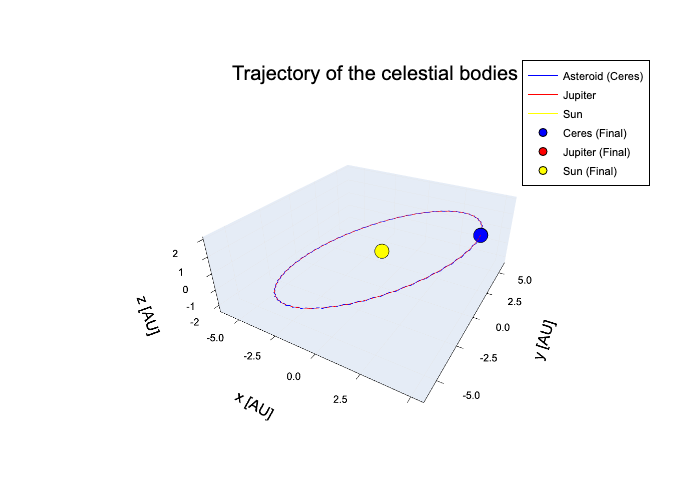

In [9]:
# TRAJECTORY OF THE CELESTIAL BODIES (STATIC)
# Assuming t, r_s, r_j, r_a have been calculated using the velocity_verlet function

# Create a 3D plot
plotlyjs()
fig = plot3d()

# Plot the trajectories
plot!(fig, r_a[:, 1], r_a[:, 2], r_a[:, 3], label="Asteroid (Ceres)", color=:blue, seriestype=:path3d)
plot!(fig, r_j[:, 1], r_j[:, 2], r_j[:, 3], label="Jupiter", color=:red, seriestype=:path3d)
plot!(fig, r_s[:, 1], r_s[:, 2], r_s[:, 3], label="Sun", color=:yellow, seriestype=:path3d)

# Plot the final positions
scatter!(fig, [r_a[end, 1]], [r_a[end, 2]], [r_a[end, 3]], label="Ceres (Final)", color=:blue)
scatter!(fig, [r_j[end, 1]], [r_j[end, 2]], [r_j[end, 3]], label="Jupiter (Final)", color=:red)
scatter!(fig, [r_s[end, 1]], [r_s[end, 2]], [r_s[end, 3]], label="Sun (Final)", color=:yellow)

# Set labels and title
xlabel!(fig, "x [AU]", use_latex=true)
ylabel!(fig, "y [AU]", use_latex=true)
zlabel!(fig, "z [AU]", use_latex=true)
title!(fig, "Trajectory of the celestial bodies", use_latex=true, fontsize=14)

# Set axis limits if needed (replace xmin, xmax, ymin, ymax, zmin, zmax with actual values)
# xlims!(xmin, xmax)
# ylims!(ymin, ymax)
# zlims!(zmin, zmax)

# Display grid
fig[:grid] = true

display(fig)


In [13]:
# Plotting function for animation
function plot_animation(t, r_s, r_j, r_a)
    anim = @animate for i in 1:20:length(t)
        plot3d(
            r_a[1:i, 1], r_a[1:i, 2], r_a[1:i, 3], label="Asteroid (Ceres)", color=:blue, seriestype=:path3d,
            xlims=(-6, 6), ylims=(-6, 6), zlims=(-6, 6),
            xlabel="x [AU]", ylabel="y [AU]", zlabel="z [AU]",
            title="Trajectory of the celestial bodies", use_latex=true, fontsize=14
        )
        plot3d!(
            r_j[1:i, 1], r_j[1:i, 2], r_j[1:i, 3], label="Jupiter", color=:red, seriestype=:path3d
        )
        plot3d!(
            r_s[1:i, 1], r_s[1:i, 2], r_s[1:i, 3], label="Sun", color=:yellow, seriestype=:path3d
        )
        
        scatter3d!(
            [r_a[i, 1]], [r_a[i, 2]], [r_a[i, 3]], label="Ceres (Current)", color=:blue
        )
        scatter3d!(
            [r_j[i, 1]], [r_j[i, 2]], [r_j[i, 3]], label="Jupiter (Current)", color=:red
        )
        scatter3d!(
            [r_s[i, 1]], [r_s[i, 2]], [r_s[i, 3]], label="Sun (Current)", color=:yellow
        )
    end
    gif(anim, "trajectories.gif", fps=15)
end

plot_animation (generic function with 1 method)

[ Info: Saved animation to /Users/karlar/MainDocuments/ClassicalMechanics/classical-mechanics/trajectories.gif


Plots.AnimatedGif("/Users/karlar/MainDocuments/ClassicalMechanics/classical-mechanics/trajectories.gif")
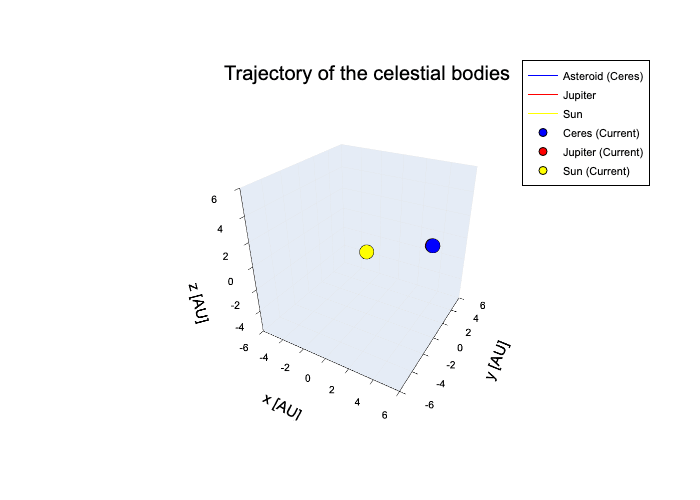

In [14]:
# Plot the animation
plot_animation(t, r_s, r_j, r_a)